In [214]:
%matplotlib inline

import pandas as pd
import numpy as np
from typing import Tuple
from sklearn.model_selection import TimeSeriesSplit


import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [215]:
np.random.seed(42)

In [216]:
data = pd.read_csv('data/Elspotprices.csv', sep=';', decimal=',')
data = data.fillna(0)
data.shape

(1647358, 5)

In [217]:
data = data[:int(1e5)]
data.shape

(100000, 5)

In [218]:
data.tail()

,HourUTC,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR
99995,2021-06-01 11:00,2021-06-01 13:00,DK1,417.339996,56.119999
99996,2021-06-01 10:00,2021-06-01 12:00,DK2,432.279999,58.130001
99997,2021-06-01 10:00,2021-06-01 12:00,DE,432.279999,58.130001
99998,2021-06-01 10:00,2021-06-01 12:00,NO2,410.489990,55.200001
99999,2021-06-01 10:00,2021-06-01 12:00,DK1,432.279999,58.130001


In [219]:
data.isnull().sum()

HourUTC         0
HourDK          0
PriceArea       0
SpotPriceDKK    0
SpotPriceEUR    0
dtype: int64

In [220]:
data.head()

,HourUTC,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR
0,2023-01-17 22:00,2023-01-17 23:00,DK1,924.799988,124.32
1,2023-01-17 22:00,2023-01-17 23:00,SE3,322.399994,43.34
2,2023-01-17 22:00,2023-01-17 23:00,NO2,924.799988,124.32
3,2023-01-17 22:00,2023-01-17 23:00,DK2,322.399994,43.34
4,2023-01-17 22:00,2023-01-17 23:00,SE4,322.399994,43.34


In [221]:
# data = data[['HourDK', 'PriceArea', 'SpotPriceDKK', 'SpotPriceEUR']]
data = data[['HourDK', 'SpotPriceEUR']]
data['HourDK'] = pd.to_datetime(data['HourDK'])


In [222]:
data.set_index('HourDK', inplace=True)
data.sort_index(inplace=True)
X = data.drop(labels=['SpotPriceEUR'], axis=1)
y = data['SpotPriceEUR']

In [223]:
tss = TimeSeriesSplit(n_splits = 3)
for train_index, test_index in tss.split(X):
    X_train_data, X_test_data = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train_data, y_test_data = y.iloc[train_index], y.iloc[test_index]

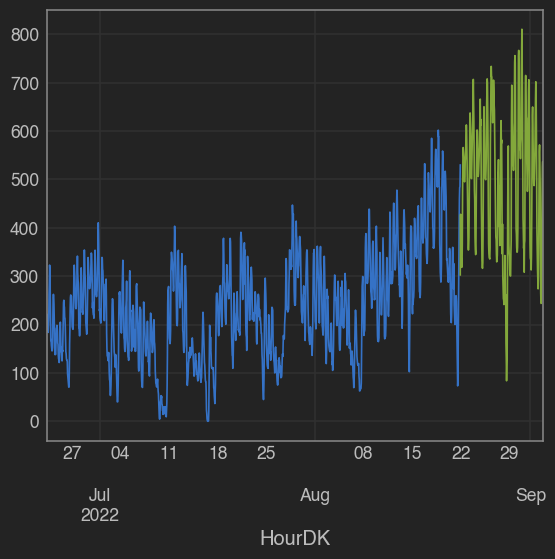

In [224]:
y_train_data[-10000:].groupby('HourDK').mean().plot()
y_test_data[:2000].groupby('HourDK').mean().plot();

In [225]:
data.dtypes

SpotPriceEUR    float64
dtype: object

In [226]:
data.describe()

,SpotPriceEUR
count,100000.000000
mean,152.483858
std,125.320548
min,-63.029999
25%,65.669998
50%,118.115002
75%,200.059998
max,871.000000


In [227]:
window_size = 7*24+24
step_size=12

first_idx, last_idx = 0, window_size
indices = []

while last_idx <= len(X_train_data)-1:
    indices.append((first_idx, last_idx))
    first_idx += step_size
    last_idx += step_size
# indices
train_window_idx = indices

In [228]:

first_idx, last_idx = 0, window_size
indices = []

while last_idx <= len(X_test_data)-1:
    indices.append((first_idx, last_idx))
    first_idx += step_size
    last_idx += step_size
# indices
test_window_idx = indices

In [229]:
input_seq_len = 7*24
target_sequence_length = 1*24


for i, idx in enumerate(train_window_idx):

    # Slice data into instance of length input length + target length
    data_instance = data['SpotPriceEUR'].to_numpy()[idx[0]:idx[1]]
    x = data_instance[0:input_seq_len]
    assert len(x) == input_seq_len
    y = data_instance[input_seq_len:input_seq_len+target_sequence_length]

    # Create all_y and all_x objects in first loop iteration
    if i == 0:
        all_y = y.reshape(1, -1)
        all_x = x.reshape(1, -1)
    else:
        all_y = np.concatenate((all_y, y.reshape(1, -1)), axis=0)
        all_x = np.concatenate((all_x, x.reshape(1, -1)), axis=0)

X_train, y_train = all_x, all_y

X_train.shape, y_train.shape

((6234, 168), (6234, 24))

In [230]:


for i, idx in enumerate(test_window_idx):

    # Slice data into instance of length input length + target length
    data_instance = data['SpotPriceEUR'].to_numpy()[idx[0]:idx[1]]
    x = data_instance[0:input_seq_len]
    assert len(x) == input_seq_len
    y = data_instance[input_seq_len:input_seq_len+target_sequence_length]

    # Create all_y and all_x objects in first loop iteration
    if i == 0:
        all_y = y.reshape(1, -1)
        all_x = x.reshape(1, -1)
    else:
        all_y = np.concatenate((all_y, y.reshape(1, -1)), axis=0)
        all_x = np.concatenate((all_x, x.reshape(1, -1)), axis=0)

X_test, y_test = all_x, all_y

X_test.shape, y_test.shape

((2068, 168), (2068, 24))

In [231]:
hyperparameters = {
    "in_length" : 7*24,
    "step_size" : 12,
    "n_estimators" : 20,
    "max_depth" : 6,
    "subsample" : 0.5,
    "min_child_weight" : 1,
    # "selected_features" : [target_variable]
    }

In [232]:
# Initialize model
model = xgb.XGBRegressor(
    n_estimators=hyperparameters["n_estimators"],
    max_depth=hyperparameters["max_depth"],
    subsample=hyperparameters["subsample"],
    min_child_weight=hyperparameters["min_child_weight"],
    objective="reg:squarederror",
    tree_method="hist"
    )

# trained_model = MultiOutputRegressor(model).fit(X_train, y_train)
# train_forecasts = trained_model.predict(x_train)

In [233]:

trained_model = MultiOutputRegressor(model).fit(X_train, y_train)
train_forecasts = trained_model.predict(X_train)


In [234]:
test_forecasts = trained_model.predict(X_test)
test_mae = mean_absolute_error(y_test, test_forecasts)
print(test_mae)
print("Mean test data value: {}".format(np.mean(y_test)))

18.11926309010562
Mean test data value: 83.56011222185283


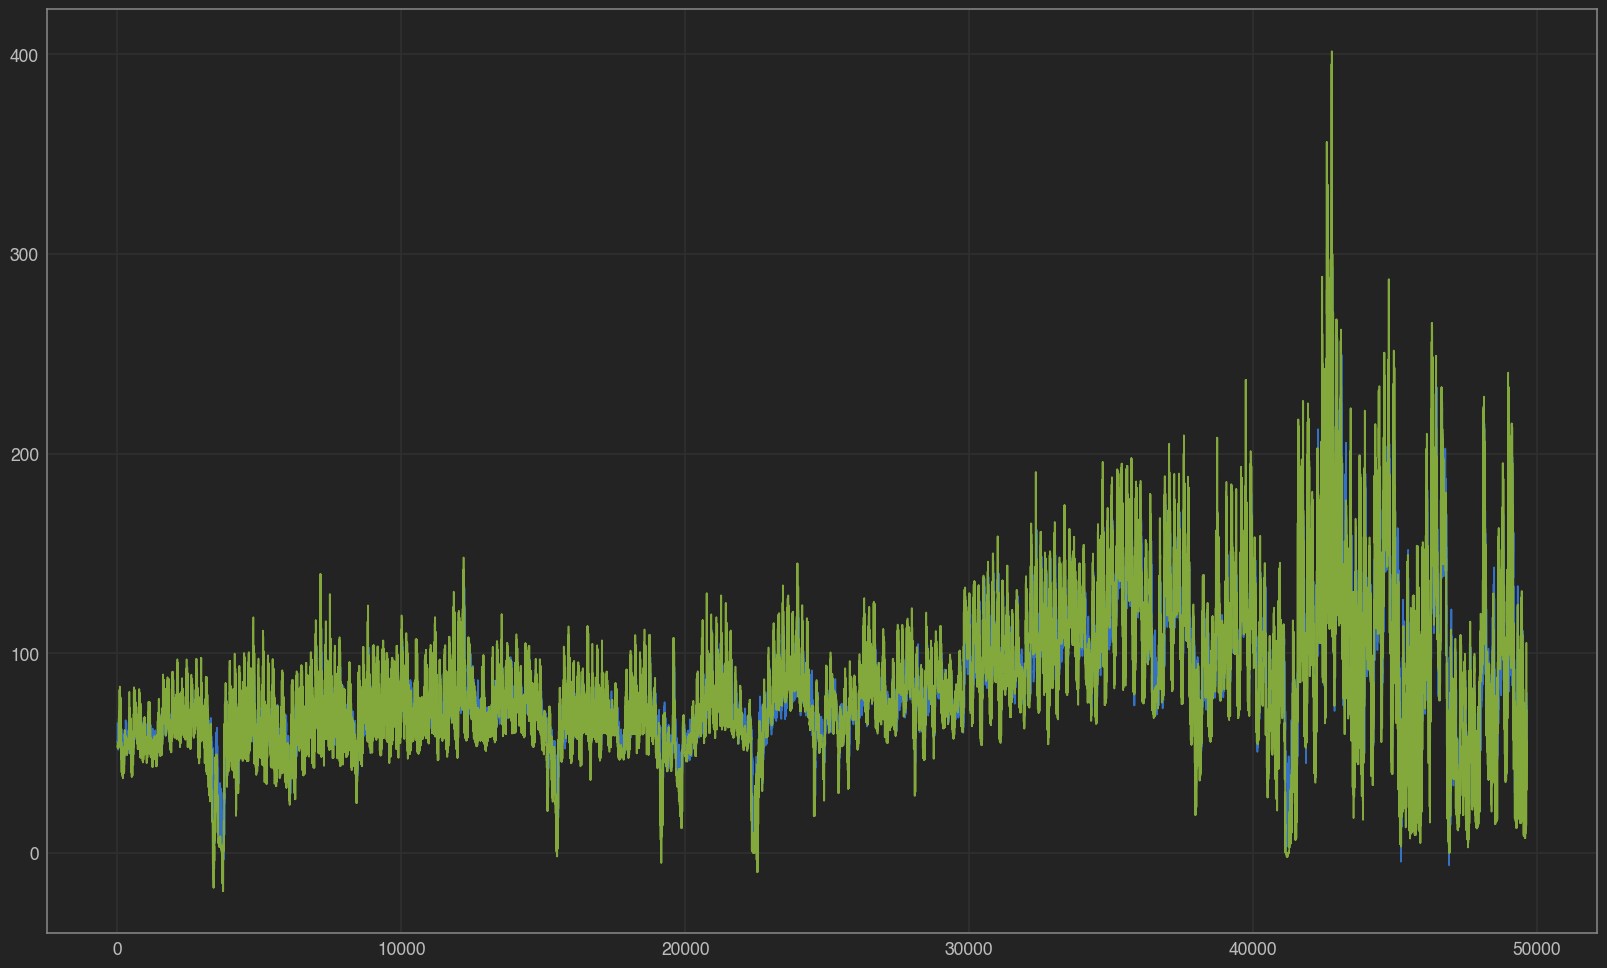

In [235]:
plot_df = pd.DataFrame(
  {"Forecasts" : test_forecasts.flatten(), "Targets" : y_test.flatten()}, 
  index=range(len(y_test.flatten()))
  )


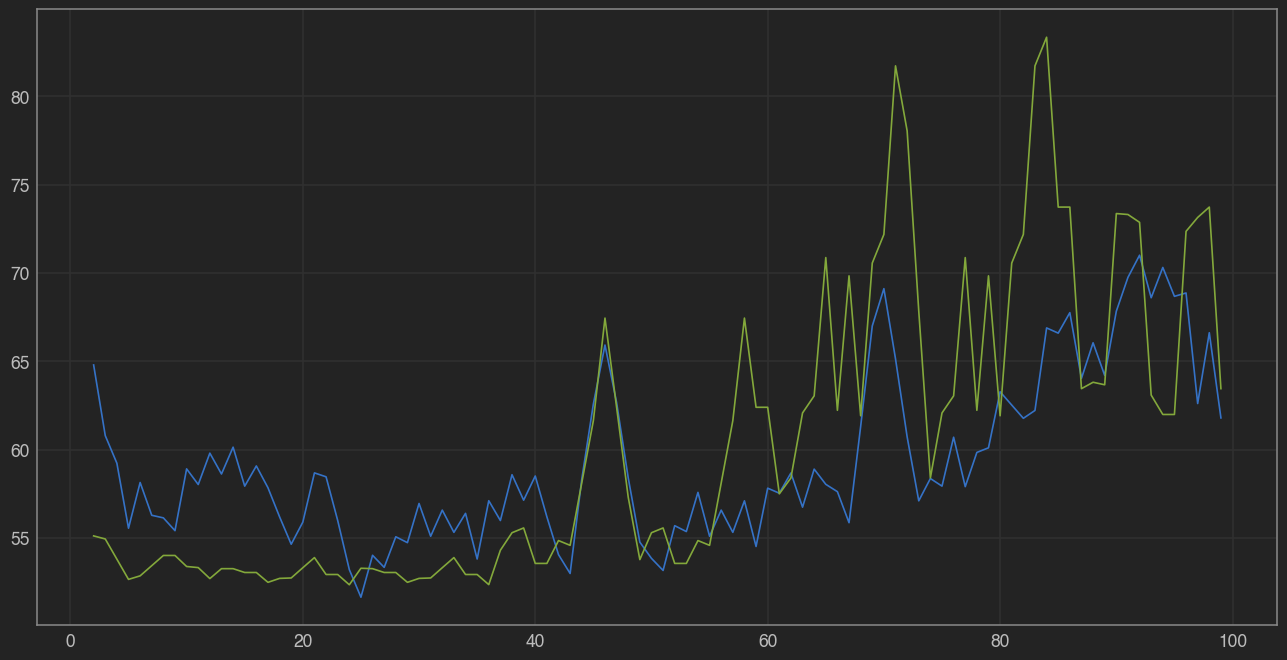

In [240]:
lim = 100

fig = plt.figure(figsize=(16,8))
plt.plot(plot_df[:lim].index, plot_df["Forecasts"].rolling(3).mean()[:lim], label="Forecasts")
plt.plot(plot_df[:lim].index, plot_df["Targets"].rolling(3).mean()[:lim], label="Targets");